# TP 5 - Using ConvNets with Data Augmentation

---
This notebook contains the code samples found in Chapter 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).

---

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in practice. Few samples means anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on classifying images as dogs or cats, in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000 images for training, 1000 for validation, and 1000 for testing.

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point, because it is impossible to train a convnet to solve a complex problem with just a few tens of samples. However, a few hundreds can 
potentially suffice if the model is small and well-regularized, and if the task is simple. Because convnets learn local, translation-invariant features, they are very data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results despite a relative lack of data, without the need for any custom feature engineering. 

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be achieved. This will get us to a classification accuracy of 72%. At that point, our main issue will be overfitting. Then we will introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve our network to reach an accuracy of 77%. 


In [1]:
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import pickle

from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.preprocessing import image

## 0. Getting the data

NOTE: The 4,000 images used in this exercise are excerpted from the "Dogs vs. Cats" dataset available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

If you are coding on **Jupyter**, execute the following two codes (otherwise skip them):

In [6]:
import wget
wget.download('https://perso.esiee.fr/~najmanl/data.zip')

100% [........................................................................] 90815954 / 90815954

'data.zip'

In [32]:
from zipfile import ZipFile
zip = ZipFile('./data.zip')
zip.extractall()

In [34]:
base_dir = './data'

If you are coding on **Google Colab**, uncomment and execute the following two codes (otherwise skip them):

In [10]:
# !wget https://perso.esiee.fr/~najmanl/data.zip -O /tmp/data.zip

--2025-03-30 13:47:20--  https://perso.esiee.fr/~najmanl/data.zip
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90815954 (87M) [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip       100%[===================>]  86.61M  23.0MB/s    in 4.9s    

2025-03-30 13:47:25 (17.8 MB/s) - ‘/tmp/data.zip’ saved [90815954/90815954]



In [11]:
# local_zip = '/tmp/data.zip'
# zip_ref = ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp')
# zip_ref.close()

In [ ]:
# base_dir = '/tmp/data'

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
# import os
# new_directory = "/content/drive/My Drive/Colab Notebooks/DeepLearningAtelier-E3FD/TP5/" # Change this path
# os.chdir(new_directory)

The contents of the .zip are extracted to the base directory (*base_dir*), which contains train and validation subdirectories for the training and validation datasets, which in turn each contain cats and dogs subdirectories. Let's define each of these directories:

In [36]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directory with our test cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')

# Directory with our test dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

If you use **Jupyter**, replace backslashes with forward slashes (useful on Windows). Otherwise, `os.path.join`creates directories such as '/data\\train\\cats' instead of '/data/train/cats'

In [38]:
train_cats_dir = train_cats_dir.replace("\\", "/")
train_dogs_dir = train_dogs_dir.replace("\\", "/")
validation_cats_dir = validation_cats_dir.replace("\\", "/")
validation_dogs_dir = validation_dogs_dir.replace("\\", "/")
test_cats_dir = test_cats_dir.replace("\\", "/")

Now, let's see what the filenames look like in the cats and dogs train directories (file naming conventions are the same in the validation directory):

In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [7]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


## 1. Image classification - Cats vs Dogs

The cats vs dogs dataset that we will use isn't packaged with Keras. It was made available as a [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data) competition in late 2013, back when convnets weren't quite mainstream. Unsurprisingly, the competition was won by entrants who used convnets. The best entries could achieve up to 95% accuracy. While the original dataset contains 25,000 images of dogs and cats, we will only use a small fraction of the data, and will still get close to 95% accuracy.

As you already know by now, data should be formatted into appropriately pre-processed floating-point tensors before being fed into our network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:
* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating-point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image  processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here.

In [9]:
# All images will be rescaled by 1./255
train_datagen  = image.ImageDataGenerator(rescale=1./255)
test_datagen = image.ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,              # This is the directory where the images are stored
        target_size=(128, 128), # All images will be resized to 128x128
        batch_size=20,
        class_mode='binary'     # Since there are only two classes, we need binary labels
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 128x128 RGB images and binary labels, with 20 samples in each batch. Note that the generator yields these batches indefinitely: it just loops endlessly over the images present in the target folder.

data batch shape: (20, 128, 128, 3)


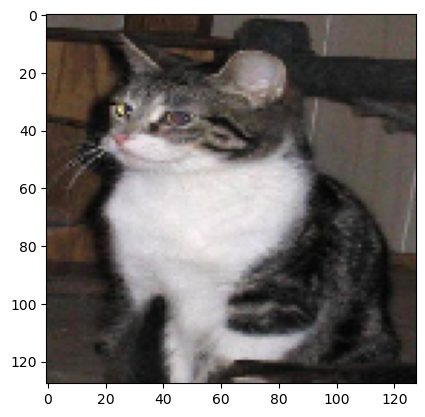

In [36]:
for data_batch, labels_batch in train_generator:

    print('data batch shape:', data_batch.shape)

    plt.imshow(image.array_to_img(data_batch[0]))
    plt.show()

    break

### 1.1 Network architecture

Like in the previous section, our convnet is a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers. However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the feature maps, so that they aren't overly large when we reach the `Flatten` layer. Since we are attacking a binary classification problem, we end the network with a single unit and a `sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

### ===== Exercise 1 =====

Complete the code below with the Keras implementation of the following convolutional network:

- Convolutional layer with **32 units**, kernel `(3, 3)`, and `'relu'` activation. *Don't forget to set `input_shape`!*

- Max pooling with `(2, 2)` downsampling.

- Convolutional layer with **64 units**, kernel `(3, 3)`, and `'relu'` activation.

- Max pooling with `(2, 2)` downsampling.

- Convolutional layer with **128 units**, kernel `(3, 3)`, and `'relu'` activation.

- Max pooling with `(2, 2)` downsampling.

- Convolutional layer with **128 units**, kernel `(3, 3)`, and `'relu'` activation.

- Max pooling with `(2, 2)` downsampling.

- Flatten layer.

- Dense layer with **512 units** and `'relu'` activation.

- Dense layer with **1 unit** and `'sigmoid'` activation.

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128, 3))) # ADD CODE HERE
model.add(layers.MaxPooling2D((2,2))) # ADD CODE HERE
model.add(layers.Conv2D(64, (3,3), activation ='relu'))       # ADD CODE HERE
model.add(layers.MaxPooling2D((2,2))) # ADD CODE HERE
model.add(layers.Conv2D(128, (3,3), activation='relu'))       # ADD CODE HERE
model.add(layers.MaxPooling2D((2,2))) # ADD CODE HERE
model.add(layers.Conv2D(128, (3,3), activation='relu'))       # ADD CODE HERE
model.add(layers.MaxPooling2D((2,2))) # ADD CODE HERE
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu')) # ADD CODE HERE
model.add(layers.Dense(1, activation='sigmoid')) # ADD CODE HERE

Let's take a look at how the dimensions of the feature maps change with every successive layer. Here, since we start from inputs of size 128x128 (a somewhat arbitrary choice), we end up with feature maps of size 6x6 right before the `Flatten` layer. Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is decreasing (from 126x126 to 6x6). This is a pattern that you will see in almost all convnets.

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,601,153 (9.92 MB)

 Trainable params: 2,601,153 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

For our compilation step, we use the Adam optimizer. Since we ended our network with a single sigmoid unit, we will use the binary cross-entropy loss.

In [20]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['acc'])

### 1.2 Baseline training

Let's fit our model to the data using the generator that we defined earlier. We do it using the `fit_generator` method, the equivalent of `fit` for data generators like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

**WARNING:** The code below takes a long time to run (around 2 hours on CPU). Run a couple of epochs to make sure that your model works fine. Then, stop the execution and skip to the next cell, where a pre-trained model is loaded.

In [22]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50
)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 48s 400ms/step - acc: 0.5319 - loss: 0.6957 - val_acc: 0.5330 - val_loss: 0.6877
Epoch 2/100
 63/100 ━━━━━━━━━━━━━━━━━━━━ 12s 350ms/step - acc: 0.5767 - loss: 0.6796


KeyboardInterrupt



It is good practice to always save your models after training.

Uncomment this line if you have trained the model yourself.

In [20]:
## Following saving codes are for both Jupyter and Colab:
# model.save("model.keras")
#
#with open("history.pickle", 'wb') as f:
#    pickle.dump(history.history, f)
#
### To verify the saved model if you use Colab:
## !ls "/content/drive/MyDrive/Colab Notebooks/DeepLearningAtelier-E3FD/TP5/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
history.pickle	model.keras  TP5_CNN_DataAugmentation_Correction.ipynb	TP5_SmallDatasets.ipynb


In this way, a trained model can be loaded back whenever it is needed.

### 1.3 Uploading Pre-trained models
Here is the model already pretrained.

In [14]:
# Comment this line if you have trained the model yourself
model = models.load_model("model.keras")

The following code loads the training history of the pre-trained model.

In [16]:
class History:
    def __init__(self, name):
        with open(name, 'rb') as file:
            h = pickle.load(file)
            self.history = h

# Comment this line if you have trained the model yourself
history = History("history.pickle")

Let's plot the loss and accuracy of the model over the training and validation data during training:

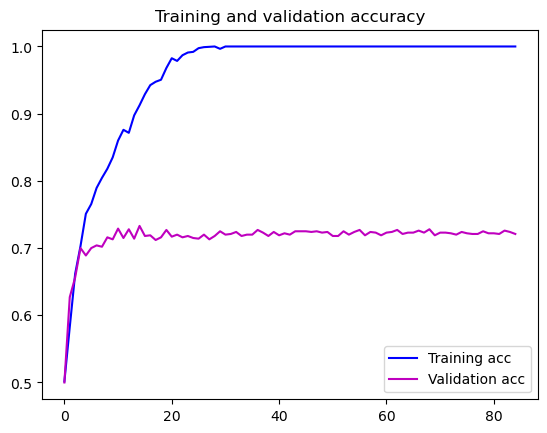

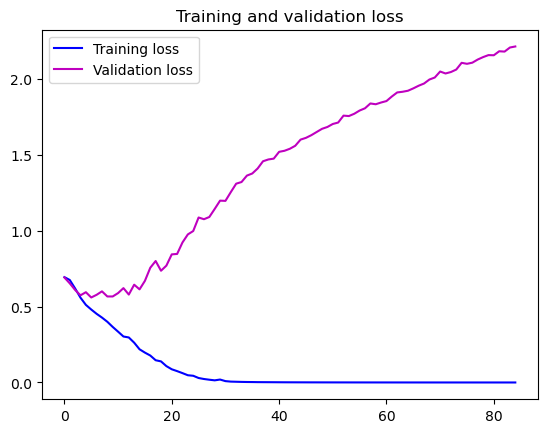

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our validation accuracy stalls at 70-75%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss keeps decreasing linearly until it reaches nearly 0. Let's evaluate this model on the test data to confirm that the model is indeed overfitted.

In [20]:
test_loss, test_acc = model.evaluate(test_generator, steps=50)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - acc: 0.7094 - loss: 2.3919
Test accuracy: 73.80%


Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data augmentation*.

## Loading and preparing the data (if necessary for TD5.2)

### For **JUPYTER** users:

In [2]:
base_dir = './data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directory with our test cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')

# Directory with our test dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

train_cats_dir = train_cats_dir.replace("\\", "/")
train_dogs_dir = train_dogs_dir.replace("\\", "/")
validation_cats_dir = validation_cats_dir.replace("\\", "/")
validation_dogs_dir = validation_dogs_dir.replace("\\", "/")
test_cats_dir = test_cats_dir.replace("\\", "/")

# All images will be rescaled by 1./255
train_datagen  = image.ImageDataGenerator(rescale=1./255)
test_datagen = image.ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,              # This is the directory where the images are stored
        target_size=(128, 128), # All images will be resized to 128x128
        batch_size=20,
        class_mode='binary'     # Since there are only two classes, we need binary labels
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### For **COLAB** users:

In [ ]:
!wget https://perso.esiee.fr/~najmanl/data.zip -O /tmp/data.zip

local_zip = '/tmp/data.zip'
zip_ref = ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/data'

from google.colab import drive
drive.mount("/content/drive")

new_directory = "/content/drive/My Drive/Colab Notebooks/DeepLearningAtelier-E3FD/TP5/" # Change this path
os.chdir(new_directory)

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directory with our test cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')

# Directory with our test dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

# All images will be rescaled by 1./255
train_datagen  = image.ImageDataGenerator(rescale=1./255)
test_datagen = image.ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,              # This is the directory where the images are stored
        target_size=(128, 128), # All images will be resized to 128x128
        batch_size=20,
        class_mode='binary'     # Since there are only two classes, we need binary labels
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary')

## 2. Data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better. In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` instance. Let's get started with an example:

In [3]:
datagen = image.ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry.

* For more transformations: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Let's take a look at our augmented images:

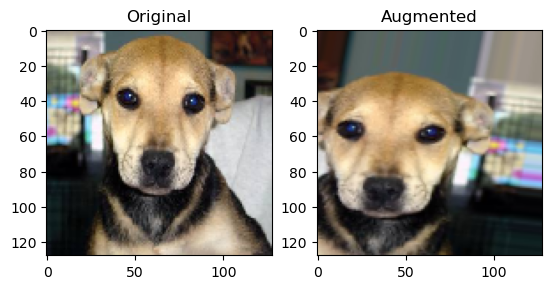

In [25]:
# We pick one image to "augment"
img = image.load_img(train_dir+"/dogs/dog.4.jpg", target_size=(128, 128))

# Convert it to a Numpy array with shape (128, 128, 3)
x = image.img_to_array(img)

# Reshape it to (1, 128, 128, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
batch = datagen.flow(x, batch_size=1)[0]

fig = plt.figure()

fig.add_subplot(121)
plt.imshow(img)
plt.title("Original")

fig.add_subplot(122)
plt.imshow(image.array_to_img(batch[0]))
plt.title("Augmented")

plt.show()

### 2.1 Augmenting training data

Now, let's define a new generator for training data that include data augmentation. Note that **the validation and test data should not be augmented!**

In [9]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.


### 2.2 Augmented training

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight overfitting, we will also add a `Dropout` layer to our model, right before the densely-connected classifier.

### ===== Exercise 2 =====

Complete the code below by adding [`Dropout`](https://keras.io/layers/core/) layers with `rate=0.5`.

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.5))  # ADD CODE HERE
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['acc'])

C:\Users\ercans\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Let's train our network using data augmentation and dropout.

**WARNING:** The code below takes a long time to run (around 3 hours on CPU). Run a couple of epochs to make sure that your model works fine. Then, stop the execution and skip to the next cell, where a pre-trained model is loaded.

In [13]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50
)

Epoch 1/100


C:\Users\ercans\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 605ms/step - acc: 0.5162 - loss: 0.6943 - val_acc: 0.5000 - val_loss: 0.6995
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - acc: 0.5239 - loss: 0.6895


KeyboardInterrupt



Uncomment this line if you have trained the model yourself.

In [35]:
#model.save("augmentedmodel.keras")
#
#with open("augmentedhistory.pickle", 'wb') as f:
#    pickle.dump(history.history, f)
#
### To verify the saved model if you use Colab:
## !ls "/content/drive/MyDrive/Colab Notebooks/DeepLearningAtelier-E3FD/TP5/"

The following code loads the pre-trained model, along with its training history.

In [13]:
# Comment these lines if you have trained the model yourself
class History:
    def __init__(self, name):
        with open(name, 'rb') as file:
            h = pickle.load(file)
            self.history = h


model = models.load_model("augmentedmodel.keras")
history = History("augmentedhistory.pickle")

Let's plot our results again.

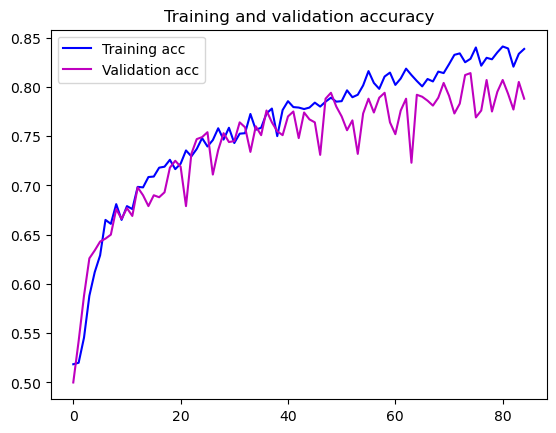

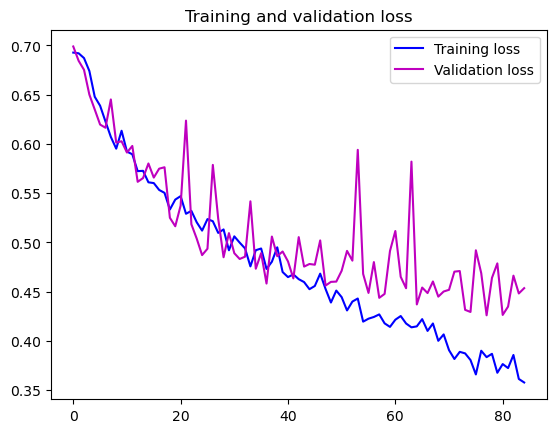

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation curves. We are now able to reach an accuracy of 77%. Let's evaluate this model on the test data to confirm the model's accuracy.

In [17]:
test_loss, test_acc = model.evaluate(test_generator, steps=50)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

C:\Users\ercans\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - acc: 0.7752 - loss: 0.4881
Test accuracy: 78.60%


By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 76-78%. However, it would prove very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next section.

## Take-away: using ConvNets with data augmentation

Here's what you should take away from the exercises of these past two sections:

* Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very small dataset, with decent results.

* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image data.

Now you have another tool for dealing with image classification problems, in particular with small datasets: data augmentation.